<a href="https://colab.research.google.com/github/kentarohamada/hctsa/blob/master/MNIST_FC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Google Colab上でChainer環境をセットアップするコマンド
!curl https://colab.chainer.org/install | sh -

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   2931      0 --:--:-- --:--:-- --:--:--  2925
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.
+ pip install -q cupy-cuda100  chainer 
     |████████████████████████████████| 335.2MB 45kB/s 
+ set +ex
Installation succeeded!


In [0]:
# 各種ライブラリのインポート
import os
import numpy as np # numpyライブラリをnpという名前で使えるようにする。numpyは行列やベクトル演算に長けたライブラリ。
import chainer
import chainer.functions as F
import chainer.links as L
import chainer.initializers as I
from chainer import training
from chainer.training import extensions
from chainer.functions.loss.softmax_cross_entropy import softmax_cross_entropy
import matplotlib.pyplot as plt
import matplotlib
from PIL import Image

In [3]:
# データセットをダウンロードし，変数に格納する処理
train, test = chainer.datasets.get_mnist(scale=255) 
# ダウンロードと同時に正規化（0〜1への値に変換する）
# scale=1で正規化あり，scale=255が正規化なしとなります

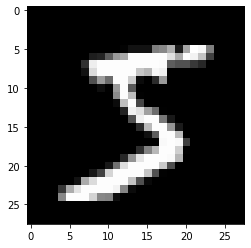

In [4]:
# ダウンロードしたデータを可視化
plt.imshow(train[0][0].reshape(28, 28), cmap="gray")

In [0]:
###
### Class: MNIST Neural Network  
### 
class DNN(chainer.Chain):
    def __init__(self):        
        super(DNN, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, 512) # 2入力2出力の全結合層
            self.l2 = L.Linear(None, 512) # 同じ
            self.l3 = L.Linear(None, 10) # 2入力2出力の全結合層

    # forward
    def __call__(self, x):
        h = self.l1(x)
        h = F.relu(h)
        h = self.l2(h)
        h = F.relu(h)  # まとめて h = F.relu(self.l2(h)) とも書ける（インライン表記）
        h = self.l3(h)
        return h

In [7]:
device = 0 # GPUを使う場合には0を指定（使わないときは-1にする）
minibatchsize = 50 # ミニバッチサイズ
epoch = 20 # エポック
outdir = 'result' # 出力先フォルダ名

# モデルのインスタンス化。「Classifier」というラッパーを使うことで分類器を学習させるようにする。
model = L.Classifier(DNN(), lossfun=F.softmax_cross_entropy)
# GPUを使うためのおまじない
chainer.cuda.get_device(0).use()
model.to_gpu(device)


# オプティマイザのセットアップ。今回はAdamを使う
optimizer = chainer.optimizers.Adam(alpha=0.01) # alphaが初期学習率（省略すると0.001）
optimizer.setup(model)

# イテレーターのセットアップ
train_iter = chainer.iterators.SerialIterator(train, minibatchsize, repeat=True, shuffle=False)
test_iter = chainer.iterators.SerialIterator(test, minibatchsize, repeat=False, shuffle=False)

# トレーナーのセットアップ
updater = training.updaters.StandardUpdater(train_iter, optimizer, device=device)
trainer = training.Trainer(updater, (epoch, 'epoch'), out=outdir)

# 評価セット
trainer.extend(extensions.Evaluator(test_iter, model, device=device))

# 実行中にログを出力する
trainer.extend(extensions.LogReport())

# 訓練・評価データに対する損失と精度の変化をグラフにプロットする
trainer.extend(
    extensions.PlotReport(['main/loss', 'validation/main/loss'],
                              'epoch', file_name='loss.png'))
trainer.extend(
    extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'],
            'epoch', file_name='accuracy.png'))

# ログで出力する内容を指定
trainer.extend(extensions.PrintReport(
    ['epoch', 'main/loss', 'validation/main/loss',
         'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

# プログレスバーの表示（見にくいのでコメントアウト）
# trainer.extend(extensions.ProgressBar())

# 学習の実行
trainer.run()

# モデルの保存
model.to_cpu() # GPU形式-->CPU形式に変換
outmodelname = os.path.join(outdir, 'MNIST_DNN.model')
chainer.serializers.save_npz(outmodelname, model) # モデルを保存する

epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
1           6.68555     2.00984               0.199133       0.2078                    13.868        
2           1.99566     1.9843                0.212216       0.2138                    19.1956       
3           1.98556     1.98221               0.218433       0.2158                    24.4967       
4           1.98671     1.98257               0.211333       0.2144                    29.8299       
5           1.98317     1.99534               0.212283       0.2212                    35.2771       
6           1.98517     1.99483               0.209966       0.2146                    40.7061       
7           1.99967     1.98237               0.208116       0.2132                    46.1084       
8           1.98344     1.98446               0.209966       0.2132                    51.4953       
9           1.99088     1.985                 0.2091         0.2129                 

In [9]:
# テストデータの推論

img = Image.open("4-3.png").convert("L").resize((28, 28))
img = (255 - np.array(img, dtype=np.uint8)) / 255.
img = (img > 0.1) * 1.0
plt.imshow(img, cmap="gray")
x = F.flatten(np.float32(img))
x = x[np.newaxis, :]
with chainer.using_config('train', False):
    y = model.predictor(x)
y = F.softmax(y).data
print(y.argmax())
for i in range(10):
    print(i, y[0][i])

FileNotFoundError: ignored